#### **In this notebook, the ROBERTa model was tested on the Test Data. **

## **`Importing Libraries`**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification

## **`Loading Test Data`**

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Fake_News_Classification/Data/test.tsv', delimiter='\t')
test_df.head()

,Unnamed: 0,title,text,subject,date,label
0,8104,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,"February 14, 2016",0
1,7467,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politicsNews,"November 9, 2016",1
2,9473,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,"Nov 9, 2017",0
3,276,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politicsNews,"December 7, 2017",1
4,19274,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left-news,"Jan 21, 2017",0


In [ ]:
print(f"Test Dataset Size: {test_df.shape}")

Test Dataset Size: (8267, 6)


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8267 entries, 0 to 8266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8267 non-null   int64 
 1   title       8267 non-null   object
 2   text        8267 non-null   object
 3   subject     8267 non-null   object
 4   date        8267 non-null   object
 5   label       8267 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 387.6+ KB


In [ ]:
test_df['label'].value_counts()

,count
label,
0,4284
1,3983


In [ ]:
test_df['full_text'] = test_df['title'] + " " + test_df['text']

In [ ]:
test_df.head()

,Unnamed: 0,title,text,subject,date,label,full_text
0,8104,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,"February 14, 2016",0,Conservatives Will HATE What Donald Trump Just...
1,7467,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politicsNews,"November 9, 2016",1,Trump victory may create new tension between U...
2,9473,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,"Nov 9, 2017",0,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...
3,276,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politicsNews,"December 7, 2017",1,"Democratic Senator Franken to resign: CNN, cit..."
4,19274,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left-news,"Jan 21, 2017",0,GANG OF DOMESTIC TERRORISTS Violently Attack L...


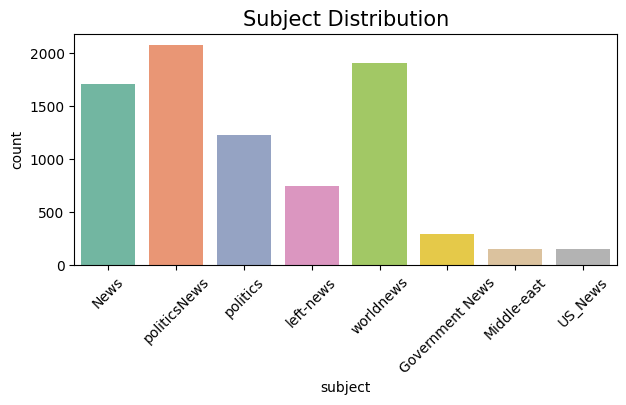

In [ ]:
#Plotting the visulization for better understanding the distribution
plt.figure(figsize=(7, 3))
sns.countplot(data=test_df, x='subject', hue='subject', palette='Set2')
plt.title('Subject Distribution', fontsize=15)
plt.xticks(rotation=45)
plt.show()

## **`Load the Roberta Model & Tokenizer`**

In [ ]:
model_path = "/content/drive/MyDrive/Fake_News_Classification/Saved_Models/roberta_model"

tokenizer_path = "/content/drive/MyDrive/Fake_News_Classification/Saved_Models/roberta_tokenizer"

In [ ]:
# Loading the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)

In [ ]:
# Load the model
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## **`Prediction Function`**

In [ ]:
def predict_news_article(article_text):
    """Predicts if a news article is Fake or Real."""
    # Tokenize input text
    inputs = tokenizer(article_text, truncation=True, padding=True, max_length=512, return_tensors="pt")

    # Forward pass (disable gradient calculation for efficiency)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get class prediction (0=Fake, 1=Real)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

## **`Apply Prediction on full_text Column`**

In [ ]:
# Applying function to create new 'predicted_label' column
test_df["predicted_label"] = test_df["full_text"].apply(lambda x: predict_news_article(str(x)))

In [ ]:
test_df[["full_text", "label", "predicted_label"]].head()

,full_text,label,predicted_label
0,Conservatives Will HATE What Donald Trump Just...,0,0
1,Trump victory may create new tension between U...,1,1
2,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,0,0
3,"Democratic Senator Franken to resign: CNN, cit...",1,1
4,GANG OF DOMESTIC TERRORISTS Violently Attack L...,0,0


## **`Evaluate Performance`**

In [ ]:
# Compute Accuracy
accuracy = accuracy_score(test_df["label"], test_df["predicted_label"])
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9994


In [ ]:
# Generate classification report
report_dict = classification_report(test_df["label"], test_df["predicted_label"],
                                    target_names=["Fake News", "Real News"],
                                    output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

In [ ]:
report_df.round(4)

,precision,recall,f1-score,support
Fake News,1.0000,0.9988,0.9994,4284.0000
Real News,0.9987,1.0000,0.9994,3983.0000
accuracy,0.9994,0.9994,0.9994,0.9994
macro avg,0.9994,0.9994,0.9994,8267.0000
weighted avg,0.9994,0.9994,0.9994,8267.0000


# **`Observations:`**

* Near-perfect performance: Precision, recall, and F1-score are all ~99.94%
* Balanced predictions: Model performs equally well on Fake News & Real News
* No significant bias: Precision and recall values are close, indicating no major class imbalance issues
